### 1. The KITTI Dataset - Introduction

* The KITTI dataset has been recorded from a moving platform (Fig. 1) while driving in and around Karlsruhe, Germany.
* It includes camera images, laser scans (LIDAR), high-precision GPS measurements and IMU accelerations from a combined GPS/IMU system.
* For comprihensive technical details on the raw data check: [Vision meets Robotics: The KITTI Dataset](https://www.cvlibs.net/publications/Geiger2013IJRR.pdf)

#### 1.1 Sensor Setup

<div align="center">
  <img src="./images/sensor_setup.png" width="40%">
</div>

#### 1.2 Zip File Structure

<div align="center">
  <img src="./images/file_struc.png" width="40%">
</div>

### 2. How we'll explore the KITTI Dataset

#### Phase 1: Data Analysis
- **Camera Data**: Load and visualize 4 camera streams (2 grayscale, 2 color)
- **LiDAR Data**: Process and visualize Velodyne point clouds
- **Transforming Coordinates**: Project 3D points onto camera images using calibration
- **Annotations**: Parse trackelets.xml and overlay bounding boxes
- **Navigation**: Process GPS/IMU data and project to image space
- **Tracking**: Implement basic object tracking across frames

#### Phase 2: Package Development
- **KITTI Toolkit**: Create structured Python package for data loading and visualization

#### 2.1 Data Analysis

We'll start exploring the sequence **2011_09_26_drive_0005** (avalaible at kitti raw data website in the "City" category):

Description:
- 2011_09_26_drive_0005 (0.6 GB)
- Length: 160 frames (00:16 minutes)
- Image resolution: 1392 x 512 pixels
- Labels: 9 Cars, 3 Vans, 0 Trucks, 2 Pedestrians, 0 Sitters, 1 Cyclists, 0 Trams, 0 Misc

In [1]:
# imports
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt

import os
from pathlib import Path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### 2.1.1 Camera Data

In [30]:
# Define base path environment variable
with open("./env_vars.txt", "r") as f:
    BASE_PATH = f.readlines()[0].split("=")[1].strip()

In [31]:
# List of sensors (4 video cameras, GPU/IMU and Velodyne)
path = os.path.join(BASE_PATH, "LIDAR/KITTI/dataset/raw/city/2011_09_26/2011_09_26_drive_0005_sync/") # using synchronized and rectified data
sensors = os.listdir(path)
print(sensors)

['image_00', 'image_01', 'image_02', 'image_03', 'oxts', 'velodyne_points']


In [29]:
path

'"C:/Users/rishit.somvanshi/OneDrive - AGC/Internship 2025/"\\LIDAR/KITTI/dataset/raw/city/2011_09_26/2011_09_26_drive_0005_sync/'

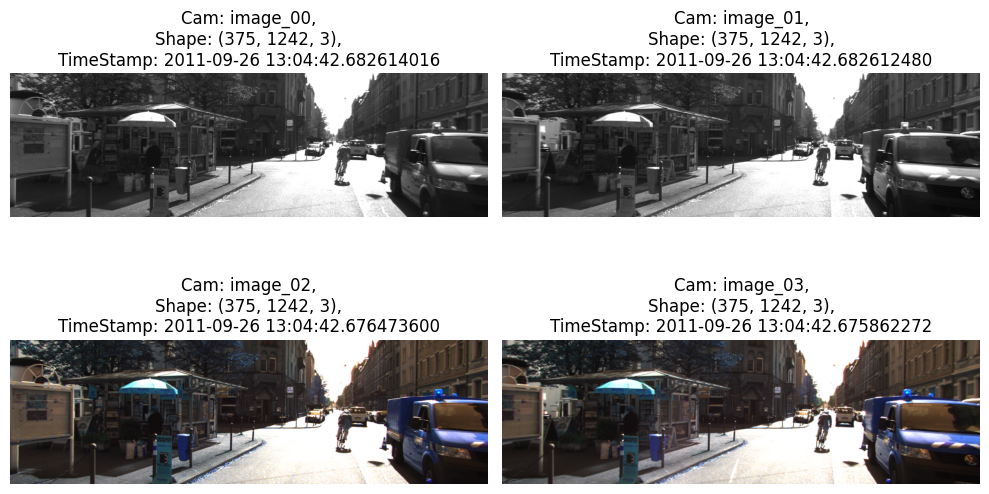

In [15]:
# A function to read and display a given frame from each of the video cameras sensors
def load_and_display_frame(seq_path: str, frame_number: int) -> None:
    '''
    Reads and displays the four frames from the 4 video cameras
    '''

    fig, axes = plt.subplots(2,2, figsize = (10,6))
    sensors = os.listdir(seq_path)
    i = 0
    for sensor in sensors:
        if sensor.startswith("image"):
            # get time stamp
            txtfile = [f for f in os.listdir(os.path.join(seq_path, sensor)) if f.endswith('.txt')][0]
            with open(os.path.join(seq_path, sensor, txtfile), 'r') as f:
                timestamp = f.readlines()[frame_number].strip()

            cam_path = os.path.join(seq_path, sensor, "data/")
            img_pth = os.path.join(cam_path, os.listdir(cam_path)[frame_number])

            # read image
            img = cv2.imread(img_pth)
            # display image
            ax = axes[i//2, i%2]
            ax.imshow(img/255)
            ax.set_title(f"Cam: {sensor},\nShape: {img.shape},\nTimeStamp: {timestamp}")
            ax.axis("off")

            i+=1
    plt.tight_layout()
    plt.show()
            
FRAME_NUMBER = 100

load_and_display_frame(path, FRAME_NUMBER)

#### 2.1.2 LiDAR Data

In [22]:
# Read and display point cloud data for frame 0 in the given sequence
def load_and_display_pcd(seq_path: str, frame_number: int) -> None:
    '''
    Reads and displays the pcd for the given frame number and sequence from the velodyne sensor
    '''

    for sensor in sensors:

        if sensor.startswith('velo'):
            # get the three time stamps (rolling shutter: start spin, end spin, camera trigger)
            txtfiles = [os.path.join(seq_path, sensor, f) for f in os.listdir(os.path.join(seq_path, sensor)) if f.endswith('.txt')]
            timestamps = [open(f, 'r').readlines()[0].strip() for f in txtfiles]
            print(timestamps)

            # get pcd data
            velo_path = os.path.join(seq_path, sensor, "data/")
            pcd_path = os.path.join(velo_path, os.listdir(velo_path)[frame_number])
            pcd = np.fromfile(pcd_path,  dtype=np.float32)
            pcd = pcd.reshape((-1,4)) # x, y, z and reflectance

            # Convert to open3d point cloud
            pcd_np = pcd[:, :3]

            pcd_o3d = o3d.geometry.PointCloud() # create point cloud object
            pcd_o3d.points = o3d.utility.Vector3dVector(pcd_np)

            # visualize:
            # o3d.visualization.draw_geometries([pcd_o3d])

load_and_display_pcd(path, FRAME_NUMBER)

['2011-09-26 13:04:32.335337762', '2011-09-26 13:04:32.386973931', '2011-09-26 13:04:32.283701593']


Zoomed in SS of the point cloud: 

<div align="center">
  <img src="./images/pcd_seq_2011_09_26_drive_0005_frame_100.jpg" width="60%">
</div>

#### 2.1.3 Transforming Coordinates

Using the intrinsic and extrinsic parameters provided in the calibration files, we can project 3D points from the LiDAR onto the camera images and vice versa.

1. Generate a colored point cloud by projecting pcd to RGB image. Read the calibration files for parameters.
   1. `calib_velo_to_cam.txt`: Has the extrinsic parameters (Rotation Matrix and Translation Vector) to transform Velo coordinates (3D) to reference camera coordinates (camera 0 3D).
   2. `calib_cam_to_cam.txt`: Has the projection matrix to transform the reference camera coordinates (camera 0 3D) to Image plane coordinates of another camera (pixel space).
   
TODO: Learn about rectification and simple stereo